Q: Use the poly() function to fit a cubic polynomial regression to predict nox using dis. Report the regression output, and plot the resulting data and polynomial fits.

                            OLS Regression Results                            
Dep. Variable:                    nox   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     210.5
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           4.16e-40
Time:                        18:56:02   Log-Likelihood:                 461.36
No. Observations:                 506   AIC:                            -918.7
Df Residuals:                     504   BIC:                            -910.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5913      0.005    117.948      0.0

<Axes: xlabel='dis', ylabel='nox'>

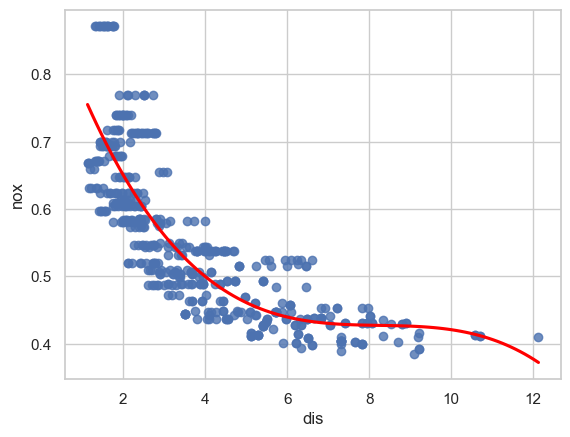

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import patsy


df = pd.read_csv("Boston.csv")

df["dis_cubed"] = np.power(df["dis"], 3)

y = df["nox"]
X = df[["dis_cubed"]]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())
sns.regplot(data=df, x="dis", y="nox", order=3, ci=None, scatter=True, line_kws={"color": "red"})

Q: Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

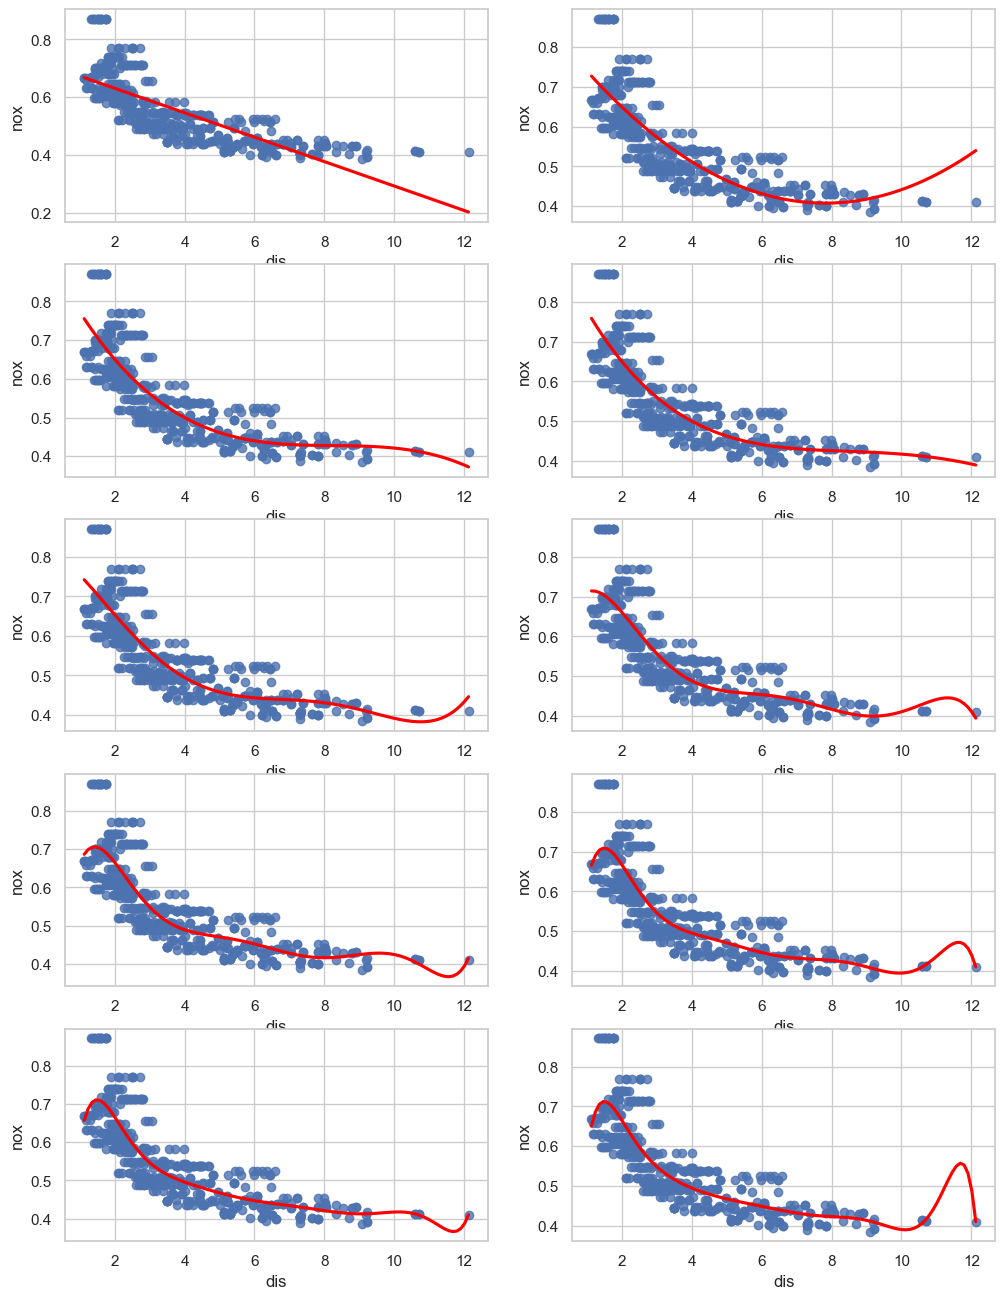

In [25]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

for degree, ax in enumerate(axs.ravel(), start=1):
    sns.regplot(data=df, x="dis", y="nox", order=degree, ci=None, scatter=True, line_kws={"color": "red"}, ax=ax)

plt.show()

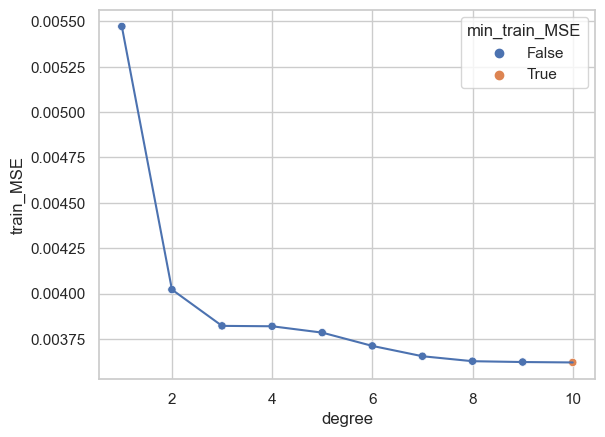

In [36]:
train_MSE = []

for i in range(1, 11):
    model_temp = sm.OLS(df["nox"], sm.add_constant(np.column_stack([df["dis"]**j for j in range(1, i+1)]))).fit()
    residuals = model_temp.resid
    train_MSE.append(np.mean(residuals**2))

result_df = pd.DataFrame({"degree": range(1, 11), "train_MSE": train_MSE})
result_df["min_train_MSE"] = result_df["train_MSE"] == result_df["train_MSE"].min()

sns.lineplot(data=result_df, x="degree", y="train_MSE")
sns.scatterplot(data=result_df, x="degree", y="train_MSE", hue="min_train_MSE")
plt.show()

Q: Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

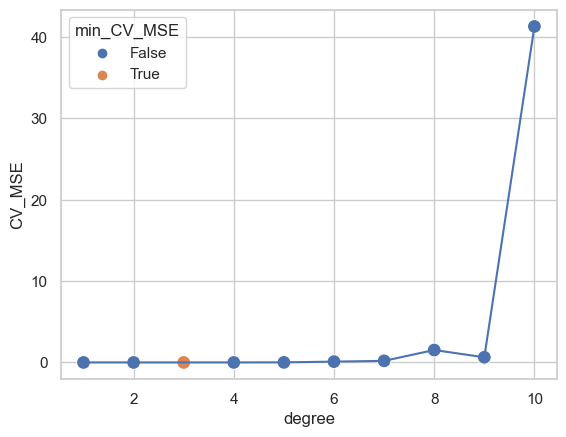

In [46]:
CV_MSE = []

for i in range(1, 11):
    model_temp = make_pipeline(PolynomialFeatures(degree=i), LinearRegression())
    mse_scores = -cross_val_score(model_temp, df[["dis"]], df["nox"], scoring="neg_mean_squared_error", cv=10)
    CV_MSE.append(np.mean(mse_scores))

result_df = pd.DataFrame({"degree": range(1, 11), "CV_MSE": CV_MSE})
result_df["min_CV_MSE"] = result_df["CV_MSE"] == result_df["CV_MSE"].min()

sns.lineplot(data=result_df, x="degree", y="CV_MSE")
sns.scatterplot(data=result_df, x="degree", y="CV_MSE", hue="min_CV_MSE", s=100)
plt.show()

A: The large spike/instability in the MSE estimate for higher-order polynomials is because of the significant flexibility in the fits. When we partition the data into 10 segments for cross-validation there will be considerable variability in the fitted model for higher values of dis (look at the previous plots and imagine how much the fitted polynomial would vary if you excluded just a few observations).

The results change considerably if we exclude outliers, e.g. where dis >= 10, which goes to show how high-variance these higher order polynomials are at the tails:

Q: Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report 
the resulting RSS. Describe the results obtained.

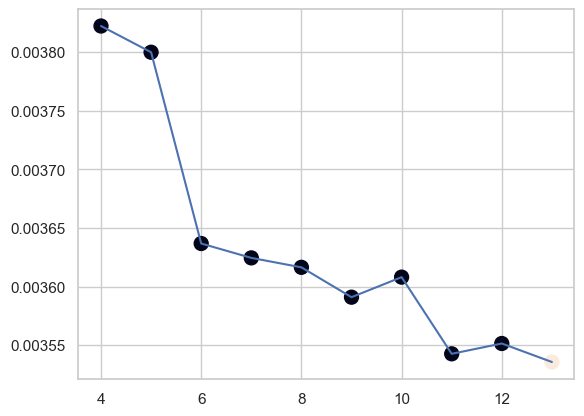

In [66]:
MSE = []

for p in range(3, 13):
    formula = f"nox ~ bs(dis, df={p})"
    y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    model_temp = sm.OLS(y, X).fit()
    residuals = model_temp.resid
    MSE.append(np.mean(residuals ** 2))

result_df = pd.DataFrame({"df": range(4, 14), "MSE": MSE})
result_df["min_MSE"] = result_df["MSE"] == result_df["MSE"].min()

plt.plot(result_df["df"], result_df["MSE"])
plt.scatter(result_df["df"], result_df["MSE"], c=result_df["min_MSE"], s=100)
plt.show()

Something happens here that was initially surprising for me - while the spline with 13 degrees of freedom (13 - 4 = 9 knots) had the lowest RSS, the trend in training RSS is not monotonic.